In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV
from catboost import CatBoostRegressor, Pool, cv

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
sns.set_context("paper", font_scale=1.5)  
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 50)

In [3]:
train = pd.read_csv('project/train.csv')
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.00,47.98,29.44,6.00,7,9.00,1969,0.09,B,B,33,7976,5,nan,0,11,B,"184,966.93"
1,15053,41,3.00,65.68,40.05,8.00,7,9.00,1978,0.00,B,B,46,10309,1,240.00,1,16,B,"300,009.45"
2,4765,53,2.00,44.95,29.20,0.00,8,12.00,1968,0.05,B,B,34,7759,0,229.00,1,3,B,"220,925.91"
3,5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,B,B,23,5735,3,"1,084.00",0,5,B,"175,616.23"
4,10783,99,1.00,39.65,23.78,7.00,11,12.00,1976,0.01,B,B,35,5776,1,"2,078.00",2,4,B,"150,226.53"


In [4]:
feature_names = train.columns
feature_names.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price']

In [5]:
target_name = ['Price']
feature_names = [
#             'Id',
#             'DistrictId',
             'Rooms',
             'Square',
#             'LifeSquare',
             'KitchenSquare',
             'Floor',
             'HouseFloor',
             'HouseYear',
             'Ecology_1',
#             'Ecology_2',
#             'Ecology_3',
             'Social_1',
             'Social_2',
             'Social_3',
#             'Healthcare_1',
             'Helthcare_2',
             'Shops_1',
#             'Shops_2',
#             'Price'
                ]

In [6]:
len(feature_names)

12

In [7]:
X_test = pd.read_csv('project/test.csv')
X_test.set_index('Id', inplace=True)
X_test = X_test[feature_names]

In [8]:
X = train[feature_names]
y = train[target_name]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((7000, 12), (3000, 12), (7000, 1), (3000, 1))

### CatBoost

Документация - https://catboost.ai/docs/concepts/about.html

In [9]:
def model_test(model, name, features, target):
    model_pred = model.predict(features)
    r2 = r2_score(target, model_pred)
    mse = mean_squared_error(target, model_pred)
    plt.scatter(target, (model_pred - target.to_numpy().flatten()))
    plt.ylabel("Predicted - real values")
    plt.xlabel("Real values")
    plt.title(name)
    plt.legend([f'R2 = {r2:.4f}, mse = {mse:.0e}'])
    plt.axhline(0, color='red');

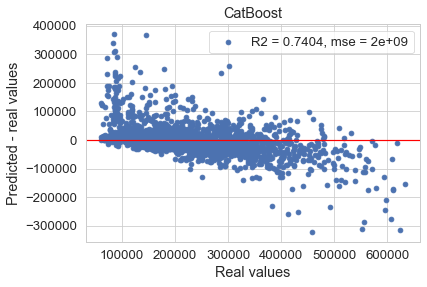

In [10]:
# используем модель с дефолтными параметрами
model_catb = CatBoostRegressor(silent=True, random_state=42)
model_catb.fit(X_train, y_train)

model_test(model_catb, 'CatBoost', X_valid, y_valid)

In [11]:
# выберем категориальные переменные по числу уникальных значений
for col in range(X_train[feature_names].shape[1]):
    print(X_train.columns[col])
    print(X_train.iloc[:,col].nunique())
    print('*' * 10)

Rooms
9
**********
Square
7000
**********
KitchenSquare
48
**********
Floor
32
**********
HouseFloor
41
**********
HouseYear
94
**********
Ecology_1
128
**********
Social_1
51
**********
Social_2
141
**********
Social_3
30
**********
Helthcare_2
7
**********
Shops_1
16
**********


In [12]:
CAT_FEATURE_NAMES = [col for col in X_train.columns if len(X_train[col].unique()) <= 10] 
for colname in CAT_FEATURE_NAMES:
    X_train[colname] = X_train[colname].astype(np.int)
    X_valid[colname] = X_valid[colname].astype(np.int) 
    X[colname] = X[colname].astype(np.int)  
cat_features = [i for i, col in enumerate(feature_names) if col in CAT_FEATURE_NAMES]
CAT_FEATURE_NAMES

['Rooms', 'Helthcare_2']

In [13]:
# plot=True дает возможность увидеть, как при обучении меняется r2 в зависимости от количества деревьев
model = CatBoostRegressor(iterations=100,
                               max_depth=7, 
                               cat_features=cat_features,
                               custom_metric='R2',
                               use_best_model=True,
                               silent=True, 
                               random_state=42)
model.fit(X_train, y_train, plot=False, eval_set=(X_valid, y_valid))

In [15]:
preds = model.predict(X_valid)
print(r2_score(y_valid, preds))

0.7325271977192429


In [17]:
# можно использовать специальные объекты данных библиотеки - Pool
train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=cat_features)
valid_pool = Pool(X_valid,
                  y_valid,
                  cat_features=cat_features) 

model = CatBoostRegressor(iterations=100, 
                          depth=7, 
                          silent=True,
                          custom_metric='R2',
                          random_state=42)

model.fit(train_pool, eval_set=valid_pool)
preds = model.predict(valid_pool)
print(r2_score(y_valid, preds))

0.7325271977192429


### Feature Importances

In [18]:
feature_importances = model.get_feature_importance(train_pool)
feature_names = X_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: \t{:.2f}'.format(name, score))

Square: 	32.11
Social_1: 	14.37
Social_3: 	13.50
Ecology_1: 	12.14
HouseYear: 	6.55
KitchenSquare: 	5.63
Social_2: 	5.09
HouseFloor: 	3.32
Floor: 	3.23
Shops_1: 	2.07
Helthcare_2: 	1.31
Rooms: 	0.68


### Кросс-валидация модели

почитать про параметры - 
https://habr.com/ru/company/otus/blog/527554/

In [19]:
model_cb = CatBoostRegressor(silent=True,
                             custom_metric='R2',
                             random_state=42)

In [20]:
%%time

cv_data = cv(
   params=model_cb.get_params(),
   pool=Pool(X, y),
   fold_count=3,
   plot=False
)

Wall time: 24min 18s


In [21]:
cv_data.tail()

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std,test-R2-mean,test-R2-std,train-R2-mean,train-R2-std
995,995,"46,534.56",718.74,"35,425.37",198.13,0.75,0.00,0.85,0.00
996,996,"46,534.48",717.93,"35,416.80",201.09,0.75,0.00,0.85,0.00
997,997,"46,535.29",718.31,"35,407.07",205.33,0.75,0.00,0.85,0.00
998,998,"46,533.82",721.48,"35,401.85",202.81,0.75,0.00,0.85,0.00
999,999,"46,532.07",724.16,"35,390.05",201.63,0.75,0.00,0.85,0.00


In [22]:
best_value = np.max(cv_data['test-R2-mean'])
best_iter = np.argmax(cv_data['test-R2-mean'])
print('Best validation r2-score: {:.4f} ± {:.4f} on step {}'.format(
   best_value,
   cv_data['test-R2-std'][best_iter],
   best_iter
))

Best validation r2-score: 0.7489 ± 0.0033 on step 991


### Подбор параметров

In [23]:
parameters = {'depth'         : [6,7,8],
              'learning_rate' : [0.03],
              'iterations'    : [100]
             }
grid = GridSearchCV(estimator=model, param_grid=parameters, cv=2, n_jobs=-1)
grid.fit(X_train, y_train)   
print("\n The best parameters:\n", grid.best_params_)


 The best parameters:
 {'depth': 6, 'iterations': 100, 'learning_rate': 0.03}
